# Importing Libraries and reading in the data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Feature Engineering, Feature Selection and Modeling Library
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [2]:
#reading in the data
train_data = pd.read_csv('traindf.csv',index_col=0, parse_dates=["Open Date"])
test_data = pd.read_csv('test.csv',index_col=0, parse_dates=["Open Date"])

In [3]:
train_data.shape, test_data.shape

((137, 42), (100000, 41))

###  'P1'-'P37' are variables that are obfuscated/unclear(i.e it may have been encoded or transformed by the original organizers of this project ). Our goal is to predict the revenue column so this is a multivariate regression problem and we can make use of different models on the dataset. Understanding the EDA of this dataset is really crucial in handling the modelling well. We have little training data and from the EDA conducted by the last team, there is a need to remove some outliers in the set and also feature engineer some new columns for modelling. 

### From what i observed, the obfuscated variables do not have significant relationship with the revenue column so most of it may not be useful for the modelling so i deduced there is a need for feature selection so that our model will have high accuracy.

In [4]:
train_data.columns[train_data.isna().any()].tolist() # No missing values in train set

[]

In [5]:
test_data.columns[test_data.isna().any()].tolist() # No missing values in test set

[]

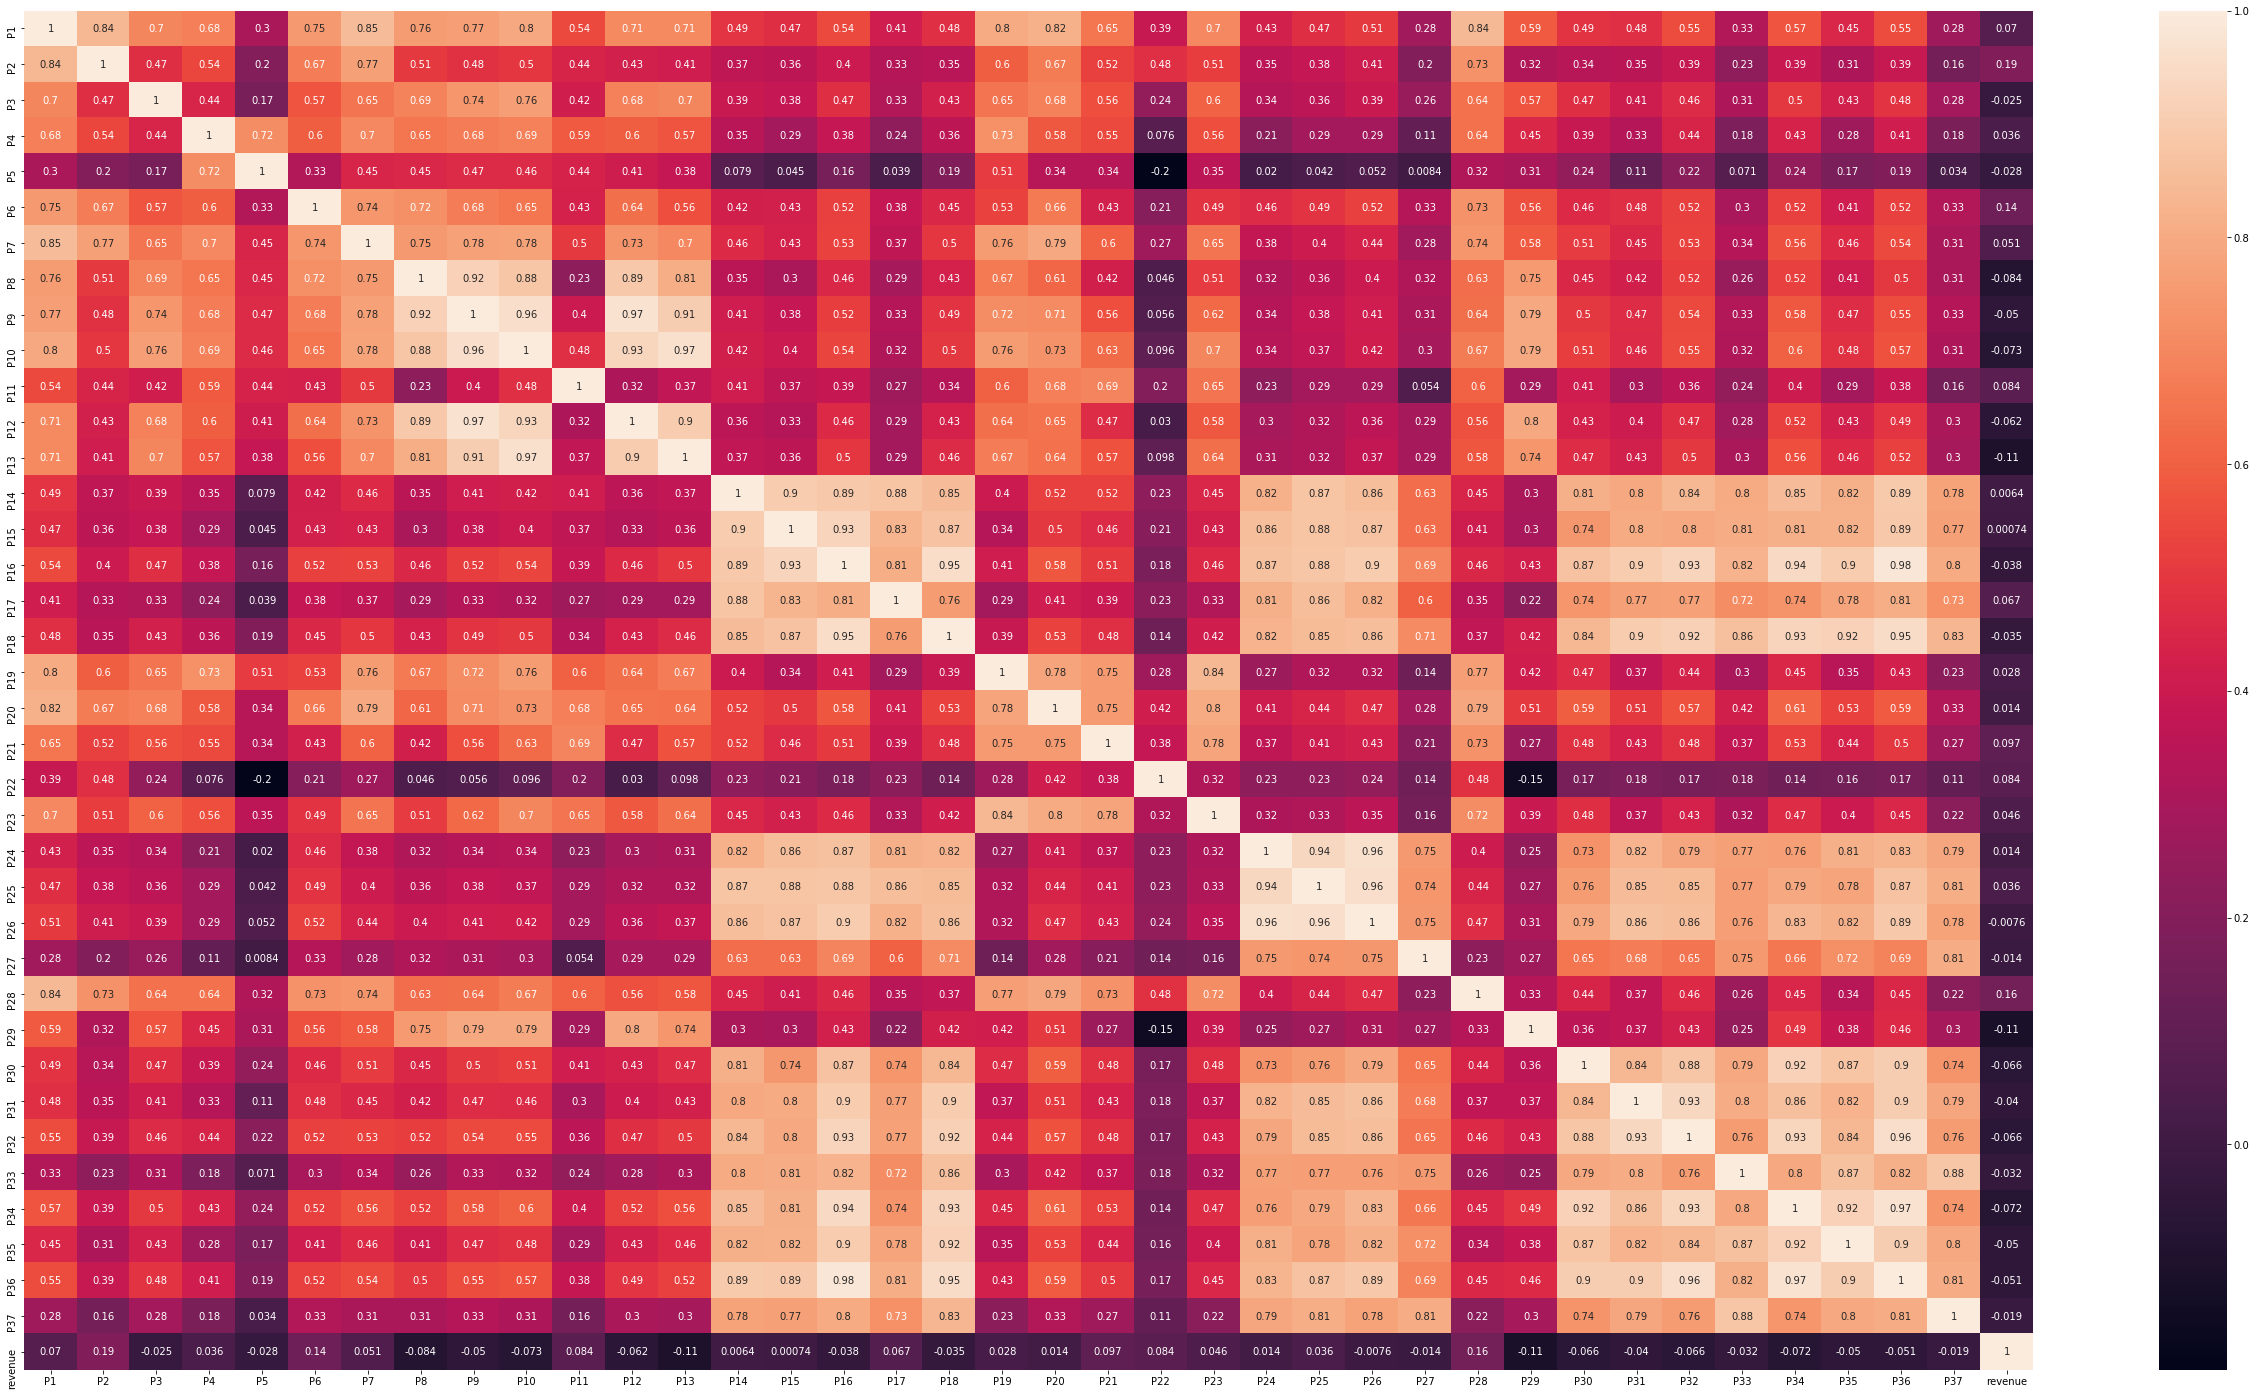

In [6]:
# From the correlation map, you can see that most of the discrete variables don't have any obvious relationship with the target column(revenue)
plt.figure(figsize=(45,25))
sns.heatmap(train_data.corr(), annot=True);

# Data Preprocessing

[Text(0, 0.5, 'Distribution'), Text(0.5, 0, 'revenue')]

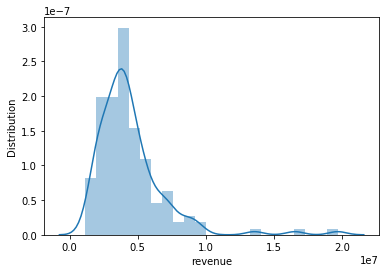

In [7]:
# From the graph below, we can see that the distribution is mostly left skewed and we have some outliers in the revenue column 

sns.distplot(train_data['revenue'], norm_hist=False, kde=True).set(xlabel='revenue', ylabel='Distribution')

In [8]:
train_data[train_data['revenue'] > 10000000 ] #Double checking the outliers so we can now safely remove them since its little

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
16,2000-01-07,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,5,...,2.0,0,0,0,0,0,0,0,0,19696939.0
75,2005-10-15,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,4,...,0.0,0,0,0,0,0,0,0,0,16549064.0
99,1999-12-18,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,4,...,1.0,5,5,4,2,5,5,5,3,13575224.0


In [9]:
# Dropping outliers
train_data = train_data[train_data['revenue'] < 10000000 ]
train_data.shape

(134, 42)

In [10]:
# Numerical columns
num_col = train_data.select_dtypes(exclude=['object']).columns

# Categorical columns
cat_col = train_data.select_dtypes(include=['object']).columns

In [11]:
num_col, cat_col

(Index(['Open Date', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
        'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19',
        'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
        'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue'],
       dtype='object'),
 Index(['City', 'City Group', 'Type'], dtype='object'))

# Feature Engineering

In [12]:
# Checking out the cardinality of the city column, we would use this in the next cell
print(train_data.groupby('City')['City'].count() / len(train_data))

City
Adana             0.022388
Afyonkarahisar    0.007463
Amasya            0.007463
Ankara            0.141791
Antalya           0.029851
Aydın             0.014925
Balıkesir         0.007463
Bolu              0.007463
Bursa             0.037313
Denizli           0.007463
Diyarbakır        0.022388
Edirne            0.007463
Elazığ            0.007463
Eskişehir         0.022388
Gaziantep         0.007463
Isparta           0.007463
Karabük           0.007463
Kastamonu         0.007463
Kayseri           0.022388
Kocaeli           0.007463
Konya             0.014925
Kütahya           0.007463
Kırklareli        0.007463
Muğla             0.014925
Osmaniye          0.007463
Sakarya           0.029851
Samsun            0.037313
Tekirdağ          0.022388
Tokat             0.007463
Trabzon           0.014925
Uşak              0.007463
İstanbul          0.350746
İzmir             0.067164
Şanlıurfa         0.007463
Name: City, dtype: float64


### Now,in the next cell, we would be modifying the 'City' Column to get the most frequent ones and label the rest as 'Rare'. Our Tolerance level is 0.05. Check the cardinality code results to understand why the tolerance level gave us 3 cities and 1 rare ........and by the way, i got the codes somewhere online so i hope you understand it :)

In [13]:
def find_non_rare_labels(df, variable, tolerance):   
    temp = df.groupby([variable])[variable].count() / len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]   
    return non_rare

def rare_encoding(X_train, X_test, variable, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

train_data, test_data = rare_encoding(train_data, test_data,'City',0.05)

In [14]:
train_data.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2013-03-09,Rare,Other,IL,2,4.0,2.0,5.0,2,3,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,2012-02-02,Rare,Other,IL,6,4.5,6.0,6.0,4,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,2009-05-09,Rare,Other,IL,3,4.0,3.0,4.0,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [15]:
train_data['City'].unique()

array(['İstanbul', 'Ankara', 'Rare', 'İzmir'], dtype=object)

### We also carry out the label encoding of the 'City', 'City Group' and 'Type' Columns

In [16]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}


def integer_encode(train_df, test_df, variable, ordinal_mapping):

    train_df[variable] = train_df[variable].map(ordinal_mapping)
    test_df[variable] = test_df[variable].map(ordinal_mapping)
    
for variable in ['City', 'City Group','Type']:
    mappings = find_category_mappings(test_data, variable)
    integer_encode(train_data, test_data, variable, mappings)

In [17]:
train_data.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,2,1,1,4,5.0,4.0,4.0,2,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,2008-02-14,1,1,0,4,5.0,4.0,4.0,1,2,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2013-03-09,0,0,1,2,4.0,2.0,5.0,2,3,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,2012-02-02,0,0,1,6,4.5,6.0,6.0,4,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,2009-05-09,0,0,1,3,4.0,3.0,4.0,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


### Next is modifying the 'Open Date' Column and generating new columns

In [18]:
from datetime import datetime as dt
def datetime_conversion(df):
    df['Open Date Year']  = df['Open Date'].dt.year
    df['Open Date Month']  = df['Open Date'].dt.month
    df['Open Date Day']  = df['Open Date'].dt.day
    all_diff = []
    for date in df["Open Date"]:
        diff = dt.now() - date
        all_diff.append(int(diff.days/1000))
    df['Days_from_open'] = pd.Series(all_diff)
    df['Days_from_open'].fillna(0, inplace=True)
    return df
    
def date_time_col(train_df,test_df):
    train_df = datetime_conversion(train_df)
    test_df = datetime_conversion(test_df)
    return train_df, test_df


In [19]:
train_data,test_data = date_time_col(train_data, test_data)

In [20]:
train_data.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P33,P34,P35,P36,P37,revenue,Open Date Year,Open Date Month,Open Date Day,Days_from_open
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,2,1,1,4,5.0,4.0,4.0,2,2,...,5,5,4,3,4,5653753.0,1999,7,17,7.0
1,2008-02-14,1,1,0,4,5.0,4.0,4.0,1,2,...,0,0,0,0,0,6923131.0,2008,2,14,4.0
2,2013-03-09,0,0,1,2,4.0,2.0,5.0,2,3,...,0,0,0,0,0,2055379.0,2013,3,9,2.0
3,2012-02-02,0,0,1,6,4.5,6.0,6.0,4,4,...,6,18,12,12,6,2675511.0,2012,2,2,3.0
4,2009-05-09,0,0,1,3,4.0,3.0,4.0,2,2,...,2,3,4,3,3,4316715.0,2009,5,9,4.0


In [21]:
# Now we seperate the predictors and target variables and drop unnedded columns
xTrain = (train_data.drop(labels=['Open Date','revenue'], axis=1))
yTrain = train_data['revenue']
xTest = test_data.drop(labels=['Open Date'], axis=1)
print(xTrain.shape, yTrain.shape, xTest.shape)

(134, 44) (134,) (100000, 44)


### Feature Selection 
#### We would make use of 'select from model' to select the best predictor features for modelling.

In [22]:
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=400,random_state=9)) #9
sel_.fit(xTrain, yTrain)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=400,
                                                random_state=9))

In [23]:
# To look at what got accepted and what got rejected
sel_.get_support()

array([ True, False, False,  True, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True])

In [24]:
selected_feat = xTrain.columns[sel_.get_support()]
print(selected_feat, len(selected_feat)) #Features to be used for prediction

Index(['City', 'P1', 'P6', 'P11', 'P19', 'P20', 'P22', 'P23', 'P28',
       'Open Date Year', 'Open Date Month', 'Open Date Day', 'Days_from_open'],
      dtype='object') 13


In [25]:
X_train = sel_.transform(xTrain)
X_test = sel_.transform(xTest)
print(X_train.shape, X_test.shape) # Applying it to the test and train set

(134, 13) (100000, 13)


### Applying StandardScaler to standardize the dataset and make it uniform

In [26]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler(with_std=True, with_mean=True, copy=True)
X_train= sc.fit_transform(X_train)
X_test=sc.transform(X_test)

### Building a randomForestRegressor model. I have tried out GBR, Xgboost, AdaBoost and some others but so far, this model has given me the best score......probably due to the nature of my feature engineering.

In [28]:
from sklearn.metrics import mean_squared_error
m = RandomForestRegressor(n_jobs=-1,n_estimators= 1000,oob_score=True, max_features=1,random_state=13)#estimmaor=1000 #max_features1, random_state=13
m.fit(X_train, yTrain)
y_hat_gbr= m.predict(X_train)
mse_gbr = mean_squared_error(yTrain, y_hat_gbr)
rmse_gbr = np.sqrt(mse_gbr)
rmse_gbr

603487.5994052321

### The parameters above were gotten with manual tweaking. I tried GridCV, RandomizedSearchCV, they were just slightly close to the score i got.......i.e my score was better :) Also note that the random_state and other parameters were carefully searched and inputted so that we can get the optimal score everytime, if you change it, your accuracy would likely decrease a little.

In [29]:
submission = pd.DataFrame(
    {
        'Id': np.arange(X_test.shape[0]), 
        'prediction':m.predict(X_test)},
    columns = ['Id', 'prediction'])
submission.to_csv(r'C:\Users\USER\16-hotel-reviews\data\SubmissionADD.csv', index = False)

### My score was 1765809.20934 on Private LB and 1763109.62755 on Public LB with this model. I hope you understand. Thanks :)